<a href="https://colab.research.google.com/github/jramassa/ml-student/blob/main/TP6/TP5_DDPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical N°6: Denoising Diffusion Probabilistic Models

See the paper introduding the DDPM : [https://arxiv.org/pdf/2006.11239.pdf](https://arxiv.org/pdf/2006.11239.pdf)

In [1]:
# Import of libraries
import imageio
import numpy as np
from argparse import ArgumentParser

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
from torchvision.datasets.mnist import MNIST

from IPython.display import Image

#Setting reproducibility
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)

# le modèle de diffusion est plus facile à entraîner que les GAN. On part du image réel auquel on ajoute du bruit.
# forward on ajoute du bruit
# backward on part du bruit pour arriver à une image, ça marche mieux de prédire le bruit à enlever plutôt que de générer l'image

In [2]:
! git clone https://github.com/relmonta/ml-student.git
! mv ml-student/TP5/* .
! mv ml-student/TP5/* .

Cloning into 'ml-student'...
remote: Enumerating objects: 404, done.
remote: Counting objects: 100% (194/194), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 404 (delta 124), reused 146 (delta 95), pack-reused 210
Receiving objects: 100% (404/404), 77.91 MiB | 26.12 MiB/s, done.
Resolving deltas: 100% (164/164), done.
mv: cannot stat 'ml-student/TP5/*': No such file or directory


## Loading data

In [3]:
def show_batch(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Convert images to CPU numpy arrays if they are PyTorch tensors
    if isinstance(images, torch.Tensor):
        images = images.detach().cpu().numpy()

    # Determine number of rows and columns
    num_images = images.shape[0]
    print(f"Plotting {num_images} images")
    rows = num_images // 8
    cols = (num_images + rows - 1) // rows  # Ensure enough columns for all images

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(cols*1, rows*1))

    # Flatten the axes array if there is only one row or column
    if rows == 1 or cols == 1:
        axes = axes.flatten()

    # Plot each image
    for idx in range(num_images):
        if idx < num_images:
            plt.subplot(rows, cols, idx + 1)
            plt.imshow(images[idx, 0, ...],cmap='winter')
            plt.axis("off")  # Turn off axis labels

    # Set the title
    fig.suptitle(title, fontsize=16)

    # Adjust layout and show the figure
    plt.tight_layout()
    plt.show()

In [4]:
# Define the transformation
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)
])

# Create the dataset with transformations
dataset = MNIST(root="./datasets", download=True, train=True, transform=normalize)

batch_size = 32
# Create the data loader
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 119965118.36it/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 37549812.10it/s]

Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 34371680.18it/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19479068.27it/s]


Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



Shape : torch.Size([32, 1, 28, 28])
Plotting 32 images


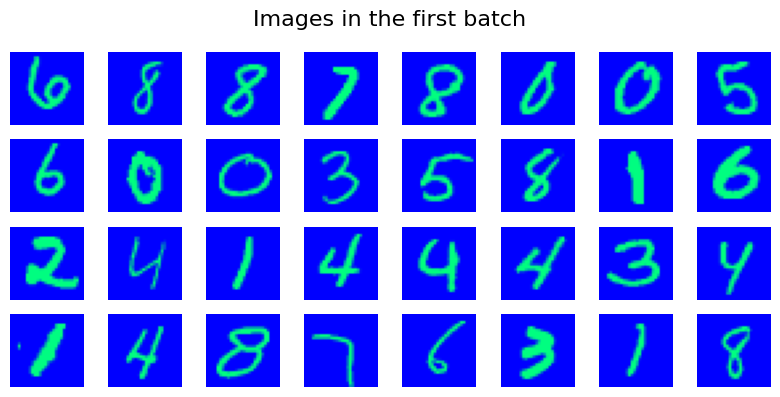

In [5]:
for images,_ in loader:
    print("Shape :",images.shape)
    show_batch(images, "Images in the first batch")
    break

In [6]:
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Exercise** : Complete the forward step, (see the training algorithm presented in the paper)

In [7]:
import math
class DDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=1e-4, max_beta=0.02, device='cuda', image_size=(1, 28, 28)):
        """
        Initialize the DDPM model.

        Parameters:
            network (nn.Module): The neural network used for estimation.
            n_steps (int): Number of steps in the DDPM algorithm.
            min_beta (float): First value for beta in the DDPM algorithm.
            max_beta (float): Last value for beta in the DDPM algorithm.
            device (str): Device for tensor computations (default is 'cuda').
            image_size (tuple): Size of the input images (default is (1, 28, 28)).
        """
        super(DDPM, self).__init__()

        # Store configuration parameters
        self.n_steps = n_steps
        self.device = device
        self.image_size = image_size

        # Move the neural network to the specified device
        self.network = network.to(device)

        # Generate beta values between min_beta and max_beta
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(device)

        # Calculate alpha values (1 - beta) and alpha bar values
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(n_steps)]).to(device)

    def forward(self, x0: torch.Tensor, t: int, eta: torch.Tensor = None) -> torch.Tensor:
        """
        Forward pass of the DDPM model.

        Parameters:
            x0 (torch.Tensor): Input image tensor.
            t (int): Current timestep in the DDPM algorithm.
            eta (torch.Tensor): Optional noise tensor (default is None).

        Returns:
            torch.Tensor: Noisy image tensor.
        """
        # Calculate alpha bar for the current timestep
        a_bar = self.alpha_bars[t].reshape(x0.shape[0], 1, 1, 1)

        # If noise is not provided, generate random noise
        if eta is None:
            eta = torch.randn(*x0.shape, device=self.device)

        # Add noise to the input image based on the calculated alpha bar
        # YOUR CODE HERE
        # raise NotImplementedError()
        noisy = a_bar.sqrt() * x0 + (1 - a_bar).sqrt() * eta
        return noisy

    def backward(self, x: torch.Tensor, t: int) -> torch.Tensor:
        """
        Backward pass of the DDPM model.

        Parameters:
            x (torch.Tensor): Input image tensor.
            t (int): Current timestep in the DDPM algorithm.

        Returns:
            torch.Tensor: Estimated noise tensor.
        """
        # Run the input image through the neural network for noise estimation
        return self.network(x, t)

In [8]:
def show_forward(ddpm, loader, device, n_images=4, n_noise_steps=5):
    """
    Show the forward process of a DDPM model.

    Parameters:
        ddpm (DDPM): Instance of DDPM model.
        loader (DataLoader): DataLoader containing batches of images.
        device (str): Device for tensor computations.
        n_images (int): Number of images to show (default to 4).
        n_noise_steps (int): number of timesteps to consider (default to 5).

    Note:
        This function visualizes the forward process, showing original images and noisy images at different steps
        in the DDPM algorithm.
    """
    # Iterate over batches in the DataLoader
    for images, _ in loader:
        imgs = images[:n_images]  # Extract the input images from the batch
        percentages = np.linspace(0,1,n_noise_steps + 1)[1:]
        noisy_images = torch.ones(imgs.shape + (n_noise_steps + 1,))
        noisy_images[...,0] = imgs

        # Iterate over different percentages of steps in the DDPM algorithm
        for i, percent in enumerate(percentages):
            # Compute the corresponding timesteps for the DDPM algorithm based on the given percentage
            timesteps = [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]
            noisy_images[...,i+1] = ddpm(imgs.to(device), timesteps)

        # Show the noisy images generated by the DDPM model for different timesteps
        rows = n_images
        cols = n_noise_steps+1
        fig, axes = plt.subplots(rows, cols, figsize=(cols*1, rows*1))

        # Plot each image
        for i in range(rows):
            for ts in range(cols):
                axes[i,ts].imshow(noisy_images[i, 0, ..., ts],cmap='winter')
                axes[i,ts].axis("off")  # Turn off axis labels
                if i==0 and ts>0:
                    axes[i,ts].set_title(f"{int(percentages[ts-1] * ddpm.n_steps)} steps ")
        axes[0,0].set_title(f"Original")

        # Set the title
        fig.suptitle("DDPM forward steps", fontsize=16)

        # Adjust layout and show the figure
        plt.tight_layout()
        plt.show()
        # Break after the first batch to avoid processing the entire dataset
        break

**Exercise** : Complete the function `generate` using the sampling algorithm presented in the paper

In [9]:
import cv2

def create_gif(frames, gif_name, frames_per_gif=10, figure_size=(10, 10), fps=10):
    """
    Create a GIF from a list of frames.

    Parameters:
        frames (list): List of frames to be included in the GIF.
        gif_name (str): Name of the GIF file.
        frames_per_gif (int): Number of times to repeat the last frame at the end.
        figure_size (tuple): Size of the figure (width, height).
        fps (int): Frames per second for the GIF.

    Returns:
        None
    """
    with imageio.get_writer(gif_name, mode="I", fps=fps) as writer:
        for idx, frame in enumerate(frames):
            if figure_size is not None:
                # Resize the frame to the specified figure size
                frame = np.expand_dims(cv2.resize(frame, figure_size), axis=-1)

            # Convert to RGB format
            rgb_frame = np.repeat(frame, 3, axis=2)
            writer.append_data(rgb_frame)

def generate(ddpm, n_samples=16, device=None, frames_per_gif=100,
             gif_name="sampling.gif", figure_size=(128, 128),neighbours=False, std=1e-1):
    """
    Generate new images using a DDPM model.

    Parameters:
        ddpm (DDPM): Instance of DDPM model.
        n_samples (int): Number of samples to be generated.
        device (str): Device for tensor computations (default is None).
        frames_per_gif (int): Number of frames to be used in the generated GIF.
        gif_name (str): Name of the generated GIF file.
        neighbours (bool): Whether to generate images starting from close values of the random noise or not.
        std (float): The standard deviation used in the case of (neighbours=True).
---> 54         noisy = np.sqrt(a_bar) * x0 + np.sqrt(1 - a_bar)
    Returns:
        torch.Tensor: Generated samples.
    """
    c, h, w=1, 28, 28 # image dimensions
    # Generate frame indices for the GIF
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        if neighbours:
            # Get a random center point
            center = torch.randn(1, c, h, w).to(device)
            x = center + std*torch.randn(n_samples, c, h, w).to(device)
        else:
            # Starting from different random noises
            x = torch.randn(n_samples, c, h, w).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            # YOUR CODE HERE
            # raise NotImplementedError()
            x = (1 / alpha_t.sqrt()) * (x - ((1 - alpha_t) / (1 - alpha_t_bar).sqrt()) * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Adding some more noise like in Langevin Dynamics
                # YOUR CODE HERE
                # raise NotImplementedError()
                x = x + sigma_t * z

            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                # Putting digits in range [0, 255]
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])

                n_sqrt = int(n_samples ** 0.5)
                frame_height = h * n_sqrt
                frame_width = w * n_sqrt
                normalized_np = normalized.cpu().numpy().astype(np.uint8)
                frame = normalized_np.reshape(n_sqrt, n_sqrt, c, h, w)
                frame = frame.transpose(0, 3, 1, 4, 2).reshape(frame_height, frame_width, c)

                # Rendering frame
                frames.append(frame)

    create_gif(frames, gif_name, frames_per_gif=frames_per_gif, figure_size=figure_size, fps=15)
    return x

The U-Net architecture used for noise estimation

In [10]:
class TimeProcessing(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(TimeProcessing, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

    def forward(self, t):
        return self.fc(t)

class ConvBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(ConvBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

class EncoderBlock(nn.Module):
    def __init__(self, time_emb_dim, in_channels, out_channels, map_size=28, downsampling=True):
        super(EncoderBlock, self).__init__()
        self.time_fc = TimeProcessing(time_emb_dim, in_channels)
        self.conv1 = ConvBlock((in_channels, map_size, map_size), in_channels, out_channels)
        self.conv2 = ConvBlock((out_channels, map_size, map_size), out_channels, out_channels)
        self.conv3 = ConvBlock((out_channels, map_size, map_size), out_channels, out_channels)
        if downsampling:
            self.downsampling = nn.Conv2d(out_channels, out_channels, kernel_size=4, stride=2, padding=1)
        else:
            self.downsampling = None

    def forward(self, x, t):
        x = x + self.time_fc(t).reshape(x.size(0), -1, 1, 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        if self.downsampling is not None:
            x = self.downsampling(x)
        return x

class BottleneckBlock(nn.Module):
    def __init__(self, time_emb_dim, in_channels, out_channels, map_size=28):
        super(BottleneckBlock, self).__init__()
        self.time_fc = TimeProcessing(time_emb_dim, in_channels)
        self.conv1 = ConvBlock((in_channels, map_size, map_size), in_channels, out_channels//2)
        self.conv2 = ConvBlock((out_channels//2, map_size, map_size), out_channels//2, out_channels//2)
        self.conv3 = ConvBlock((out_channels//2, map_size, map_size), out_channels//2, out_channels)
        self.downsampling = nn.Conv2d(out_channels, out_channels, kernel_size=4, stride=2, padding=1)
    def forward(self, x, t):
        x = x + self.time_fc(t).reshape(x.size(0), -1, 1, 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.downsampling(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, time_emb_dim, in_channels, out_channels, map_size=28, first_block=False):
        super(DecoderBlock, self).__init__()
        self.upsampling = nn.Sequential(
            nn.ConvTranspose2d(in_channels//2, in_channels//2, kernel_size=4, stride=2, padding=1),
            nn.SiLU(),
            nn.ConvTranspose2d(in_channels//2, in_channels//2, kernel_size=2, stride=1)
        )
        if not first_block:
          self.upsampling = nn.ConvTranspose2d(in_channels//2, in_channels//2, kernel_size=4, stride=2, padding=1)
        self.time_fc = TimeProcessing(time_emb_dim, in_channels)
        self.conv1 = ConvBlock((in_channels, map_size, map_size), in_channels, 2*out_channels)
        self.conv2 = ConvBlock((2*out_channels, map_size, map_size), 2*out_channels, out_channels)
        self.conv3 = ConvBlock((out_channels, map_size, map_size), out_channels, out_channels)

    def forward(self, x, t, enc_out):
        x = self.upsampling(x)
        x = torch.cat((enc_out, x), dim=1)
        x = x + self.time_fc(t).reshape(x.size(0), -1, 1, 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(UNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = self._make_sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # Encoder
        self.encoder_blocks = nn.ModuleList([
            EncoderBlock(time_emb_dim, in_channels=1, out_channels=16, map_size=28, downsampling=False),
            EncoderBlock(time_emb_dim, in_channels=16, out_channels=32, map_size=28),
            EncoderBlock(time_emb_dim, in_channels=32, out_channels=64, map_size=14)
        ])

        # Bottleneck
        self.bottleneck = BottleneckBlock(time_emb_dim, 64, 64,map_size=7)

        # Decoder
        self.decoder_blocks = nn.ModuleList([
            DecoderBlock(time_emb_dim, in_channels=128, out_channels=32, map_size=7, first_block=True),
            DecoderBlock(time_emb_dim, in_channels=64, out_channels=16, map_size=14),
            DecoderBlock(time_emb_dim, in_channels=32, out_channels=16, map_size=28)
        ])

        # Output Convolution
        self.conv_out = nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x, t):
        t = self.time_embed(t)

        # Encoder
        encoder_outputs = [x]
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x, t)
            encoder_outputs.append(x)

        # Bottleneck
        x = self.bottleneck(x, t)

        # Decoder
        for i, decoder_block in enumerate(self.decoder_blocks):
            x = decoder_block(x, t, encoder_outputs[-(i + 1)])

        # Output Convolution
        out = self.conv_out(x)

        return out

    def _make_sinusoidal_embedding(self, dim_in, dim_out):
        # Returns the standard positional embedding
        embedding = torch.zeros(dim_in, dim_out)
        wk = torch.tensor([1 / 10_000 ** (2 * j / dim_out) for j in range(dim_out)])
        wk = wk.reshape((1, dim_out))
        t = torch.arange(dim_in).reshape((dim_in, 1))
        embedding[:,::2] = torch.sin(t * wk[:,::2])
        embedding[:,1::2] = torch.cos(t * wk[:,::2])

        return embedding


**Exercise** : Instanciate the DDPM

In [11]:
# Defining model
n_steps, min_beta, max_beta = 1000, 1e-4, 0.02  # Originally used by the authors

#YOUR CODE HERE
#raise NotImplementedError()
unet = UNet(n_steps = n_steps).cuda()
ddpm = DDPM(unet, n_steps = n_steps, min_beta = min_beta, max_beta = max_beta, device = device)

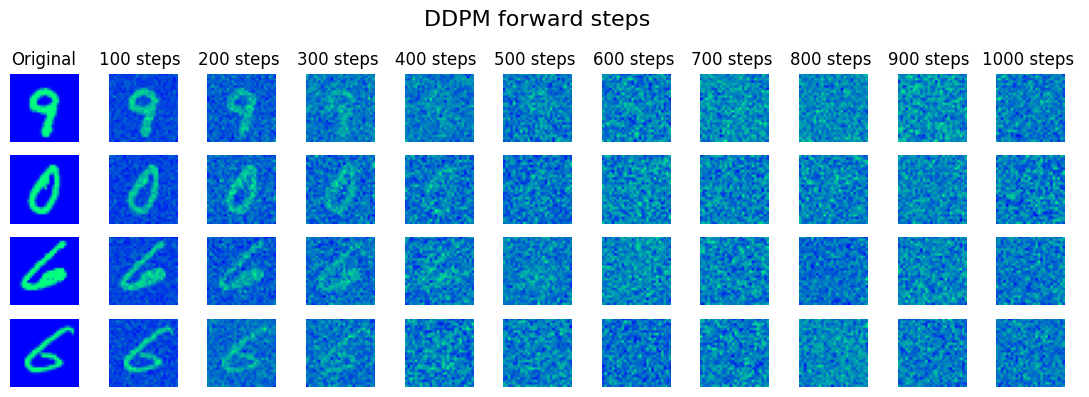

In [12]:
# Show the diffusion (forward) process
show_forward(ddpm, loader, device, n_images=4, n_noise_steps=10)

Plotting 16 images


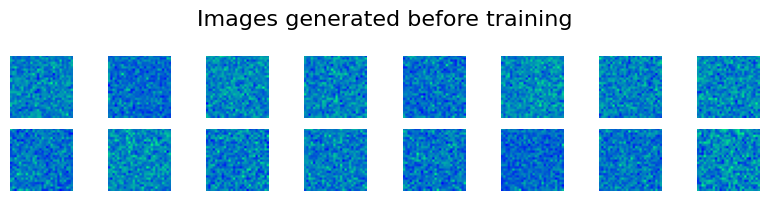

In [13]:
# Show the denoising (backward) process
generated = generate(ddpm, gif_name="before_training.gif")
show_batch(generated, "Images generated before training")

## Training Loop

The training loop is designed to iteratively optimize the parameters of our model.
For each iteration, we process a batch of our dataset. In this batch, each of the `N` images
(represented as a `(N, C, H, W)` tensor) undergoes the forward process with a unique timestep 't'.
This choice of different timesteps for each image aims to enhance training stability and model robustness.
The additional noise introduced during this forward pass is represented by a `(N, C, H, W)` tensor, denoted as $\epsilon$.

Once the forward process is complete, we aim to predict the noise $\epsilon$ from the obtained noisy images.
Our neural network, designed for the backward step, is trained to estimate the noise characteristics.
The optimization process involves minimizing the discrepancy between the predicted noise and the true noise.
We achieve this by employing a simple yet effective Mean-Squared Error (MSE) loss function.

The training loop repeats this process across multiple batches, gradually improving the model's ability
to understand and predict the noise patterns inherent in the input images.

**Exercise**: Complete the training loop

In [ ]:
def train(ddpm, loader, learning_rate=1e-3, device='cpu',n_epochs=10, display=True, store_path="ddpm_model.pt"):
    # Initialize Mean Squared Error (MSE) loss function
    mse_loss = nn.MSELoss()
    optimizer = Adam(ddpm.parameters(), lr)

    # Initialize the best loss to positive infinity
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    # Iterate through epochs
    for epoch in tqdm(range(1, n_epochs + 1), desc="Training progress", colour="#00ff00"):
        epoch_loss = 0.0

        # Iterate through batches
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch}/{n_epochs}", colour="#005500")):
            # Load data
            x0 = batch[0].to(device)
            n = x0.shape[0] # batch size

            # Generate random noise, timestep, and alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Compute the noisy image based on x0 and the time-step (forward process)
            # YOUR CODE HERE
            # raise NotImplementedError()
            noisy = ddpm.forward(x0 = x0, t = t, eta = eta)

            # Get model estimation of noise based on the images and the time-step
            # YOUR CODE HERE
            # raise NotImplementedError()
            eta_theta = ddpm.backward(noisy, t.reshape(n, -1))

            # Optimize the Mean Squared Error between the true and predicted noise
            # YOUR CODE HERE
            # raise NotImplementedError()
            loss = mse_loss(eta_theta, eta)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        epoch_loss /= len(loader)
        # Display images generated at this epoch
        if display:
            show_batch(generate(ddpm, device=device), f"Images generated at epoch {epoch}")

        # Log and store the model
        log_string = f"Loss at epoch {epoch}: {epoch_loss:.3f}"

        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)

Training progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/1875 [00:00<?, ?it/s]

Plotting 16 images


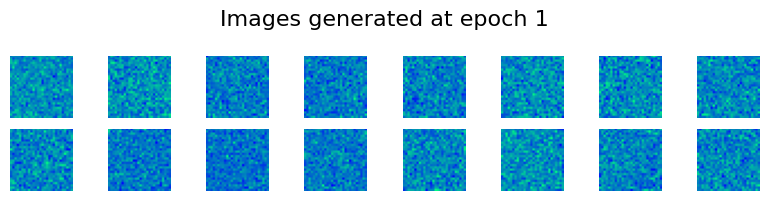

Loss at epoch 1: 1.000 --> Best model ever (stored)


Epoch 2/10:   0%|          | 0/1875 [00:00<?, ?it/s]

Plotting 16 images


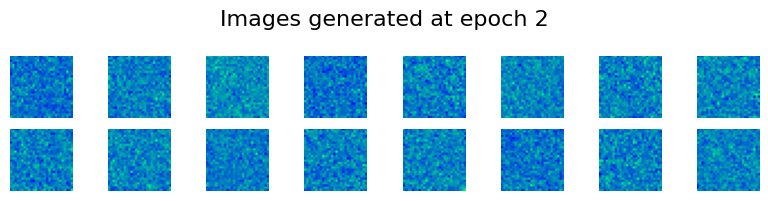

In [ ]:
# Training
store_path = "ddpm_model_normalize.pt"
batch_size = 128
n_epochs = 10
lr = 1e-4

train(ddpm, loader, n_epochs=n_epochs, learning_rate=lr, device=device, store_path=store_path)

In [ ]:
# Show the denoising (backward) process
generated = generate(ddpm, gif_name="after_training.gif")
show_batch(generated, "Images generated after training")

In [ ]:
# Loading the trained model
if false#load_pretrained:
    # Loading the trained model
    # YOUR CODE HERE
    raise NotImplementedError()
else:
    trained_model = ddpm

trained_model.eval()

In [ ]:
path = "generated.gif"
generated = generate(
          trained_model,
          n_samples=100,
          device=device,
          gif_name=path,
          figure_size=None#(400, 400)
        )
#show_batch(generated, "Generated images")
gif = open(path,'rb').read()

In [ ]:
Image(gif)

Use the `std` and `neighbours` parameters in the `generate` function to initiate the process from a specific neighbourhood within the noise space.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()
